# Installs and Imports

In [ ]:
%%capture
!pip install sentence-transformers
!pip install "tensorflow-text==2.11.*"
!pip install torch==2.1.0
!pip install transformers

In [ ]:
!rm -rf ./SentEval
!git clone https://github.com/claudiarichardxx/SentEval.git
!cd $PWD/SentEval/data/downstream && bash get_transfer_data.bash > /dev/null 2>&1

Cloning into 'SentEval'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 693 (delta 3), reused 4 (delta 2), pack-reused 683
Receiving objects: 100% (693/693), 33.25 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (435/435), done.
Updating files: 100% (39/39), done.


In [ ]:
#sys.path.append(f'{os.getcwd()}/SentEval')

In [ ]:
%%capture
import pandas as pd
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as t
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
#import senteval
import time
import requests
import numpy as np
#from sentence_transformers import SentenceTransformer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Downloading models

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
model_list = ['sentence-transformers/bert-base-nli-mean-tokens',
              'sentence-transformers/all-MiniLM-L6-v2',
              'sentence-transformers/all-mpnet-base-v2',
              #'jinaai/jina-embeddings-v2-base-en']
              #'hkunlp/instructor-xl',
              #'sentence-transformers/paraphrase-multilingual-mpnet-base-v2']
              #'SupstarZh/whitenedcse-bert-base',
              #'SupstarZh/whitenedcse-bert-large',
              'bert-base-uncased']
count = 1
models = {}
for model in model_list:
  models[model] = {'Model': AutoModel.from_pretrained(model) , 'Tokenizer' : AutoTokenizer.from_pretrained(model)}
  count = count +1

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
models.keys()

dict_keys(['sentence-transformers/bert-base-nli-mean-tokens', 'sentence-transformers/all-MiniLM-L6-v2', 'sentence-transformers/all-mpnet-base-v2', 'bert-base-uncased'])

# Setting up SentEval and evaluating

In [ ]:
Pearson = pd.DataFrame()
Spearman = pd.DataFrame()

In [ ]:
PATH_TO_DATA = f'{os.getcwd()}/SentEval/data'
MODEL = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1' #@param ['https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1', 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-large/1']
PARAMS = 'rapid prototyping' #@param ['slower, best performance', 'rapid prototyping']
TASK = ['STS12', 'STS13', 'STS14', 'STS15', 'STS16', 'SICKRelatedness','STSBenchmark' ]
#param ['CR','MR', 'MPQA', 'MRPC', 'SICKEntailment', 'SNLI', 'SST2', 'SUBJ', 'TREC']

In [ ]:
# Tasks available : ['CR', 'MR', 'MPQA', 'SUBJ', 'SST2', 'SST5', 'TREC', 'MRPC', 'SICKRelatedness', 'SICKEntailment', 'STSBenchmark', 'SNLI', 'ImageCaptionRetrieval', 'STS12', 'STS13', 'STS14', 'STS15', 'STS16', 'Length', 'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion']

In [ ]:
params_prototyping = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 5}
params_prototyping['classifier'] = {'nhid': 0, 'optim': 'rmsprop', 'batch_size': 128,
                                 'tenacity': 3, 'epoch_size': 5}

params_best = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 10}
params_best['classifier'] = {'nhid': 0, 'optim': 'adam', 'batch_size': 16,
                                 'tenacity': 5, 'epoch_size': 6}

params = params_best if PARAMS == 'slower, best performance' else params_prototyping

In [ ]:
#recommended params as per the paper
params['classifier'] = {'nhid': 0, 'optim': 'adam',
                        'batch_size': 64, 'tenacity': 5,
                        'epoch_size': 4}

In [ ]:
with open('/content/english_stopwords.txt', 'r') as file:
    stopWords = file.read().replace('\n', ',')
stopWordsList = stopWords.split(',')

In [ ]:
def batcher(params, batch):
    #Tokenize sentences
    encoded_input = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt',is_split_into_words=True)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    return sentence_embeddings

In [ ]:
def prepare(params, samples):
    sentences = []
    for i in range(0, len(samples)):
      #samples[i] = samples[i].lower()
      #word_list = samples[i].split()
      filtered_sentence = [w for w in samples if w not in stopWordsList]
      sentences.append(filtered_sentence)
    return sentences

In [ ]:
for modell in models.keys():
  model_name = modell
  model = models[modell]['Model']
  tokenizer = models[modell]['Tokenizer']
  se = senteval.engine.SE(params, batcher, prepare)
  print("Evaluating Model %s with %s parameters" % (model_name, PARAMS))
  results = se.eval(TASK)
  PearsonRow = {'Model': model_name}
  SpearmanRow = {'Model': model_name}
  for i in results.keys():
    if(i in ['SICKRelatedness','STSBenchmark']):
      col_name = i
      PearsonRow[col_name] = results[i]['pearson']
      SpearmanRow[col_name] = results[i]['spearman']
    else:
      col_name = i
      PearsonRow[col_name] = results[i]['all']['pearson']['mean']
      SpearmanRow[col_name] = results[i]['all']['spearman']['mean']
  Pearson = Pearson.append(PearsonRow , ignore_index = True)
  Spearman = Spearman.append(SpearmanRow , ignore_index = True)

In [ ]:
results

{'STS12': {'MSRpar': {'pearson': PearsonRResult(statistic=0.5489241388145122, pvalue=3.05225021506122e-60),
   'spearman': SignificanceResult(statistic=0.5611162640011131, pvalue=1.9862377468068109e-63),
   'nsamples': 750},
  'MSRvid': {'pearson': PearsonRResult(statistic=0.8770370075744122, pvalue=2.3775377243313904e-240),
   'spearman': SignificanceResult(statistic=0.8948494266434566, pvalue=3.044002460634904e-264),
   'nsamples': 750},
  'SMTeuroparl': {'pearson': PearsonRResult(statistic=0.5006361429614771, pvalue=1.724549997613736e-30),
   'spearman': SignificanceResult(statistic=0.5674038293122525, pvalue=1.8180605255898084e-40),
   'nsamples': 459},
  'surprise.OnWN': {'pearson': PearsonRResult(statistic=0.6895473533566826, pvalue=6.577008801643771e-107),
   'spearman': SignificanceResult(statistic=0.6967796200727553, pvalue=4.771867814328482e-110),
   'nsamples': 750},
  'surprise.SMTnews': {'pearson': PearsonRResult(statistic=0.6141731547499278, pvalue=9.754389862969515e-43),

In [ ]:
Pearson

,Model,STS12,STS13,STS14,STS15,STS16,SICKRelatedness,STSBenchmark
0,sentence-transformers/bert-base-nli-mean-tokens,0.646064,0.675390,0.732218,0.743410,0.701281,0.842418,0.730534
1,sentence-transformers/all-MiniLM-L6-v2,0.703392,0.743345,0.796217,0.823803,0.802868,0.866556,0.799821
2,sentence-transformers/all-mpnet-base-v2,0.723687,0.780016,0.807836,0.821690,0.823480,0.883839,0.822791
3,jinaai/jina-embeddings-v2-base-en,0.184067,0.126401,0.146057,0.138819,0.166935,0.147883,0.106115


In [ ]:
Spearman

,Model,STS12,STS13,STS14,STS15,STS16,SICKRelatedness,STSBenchmark
0,sentence-transformers/bert-base-nli-mean-tokens,0.638003,0.693433,0.729385,0.751605,0.732674,0.792747,0.736279
1,sentence-transformers/all-MiniLM-L6-v2,0.700075,0.744588,0.759306,0.833996,0.813170,0.795573,0.805764
2,sentence-transformers/all-mpnet-base-v2,0.707838,0.778767,0.777563,0.832907,0.831551,0.831836,0.828680
3,jinaai/jina-embeddings-v2-base-en,0.186478,0.102644,0.143657,0.126764,0.162357,0.133223,0.099464


In [ ]:
Pearson.to_excel('PearsonFirstFour.xlsx')
Spearman.to_excel('SpearmanFirstFour.xlsx')

In [ ]:
from google.colab import files
files.download('PearsonFirstFour.xlsx')
files.download('SpearmanFirstFour.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Classification

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import torch
from collections import Counter

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv('/content/bbc-text.csv')

In [ ]:
# Data Preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove punctuation and other non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [ ]:
def get_encoding(text):
    #Tokenize sentences
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt',is_split_into_words=True)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    return sentence_embeddings

In [ ]:
data['tokens'] = data['text'].apply(preprocess_text)

In [ ]:
# Word2Vec Embedding
word2vec_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=7, min_count=3, workers=4)

In [ ]:
data

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [ ]:
def word2vec_embedding(tokens):
    # Calculate the mean vector for the tokens in each document
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if not vectors:
        return None
    return sum(vectors) / len(vectors)

data['word2vec'] = data['tokens'].apply(word2vec_embedding)
# Classification with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(data[['word2vec']], data['category'], test_size=0.2, random_state=42)

# Logistic Regression with Word2Vec
logreg_word2vec = LogisticRegression(max_iter=1000)
logreg_word2vec.fit(X_train['word2vec'].to_list(), y_train)
y_pred_word2vec = logreg_word2vec.predict(X_test['word2vec'].to_list())
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(f'Logistic Regression accuracy with Word2Vec: {accuracy_word2vec}')

Logistic Regression accuracy with Word2Vec: 0.9303370786516854


In [ ]:
AccuracyDf = pd.DataFrame()

In [ ]:
#Check on list of models
for key in models.keys():
  print(key)
  print(models[key]['Model'])

In [ ]:
def reshape(arr):
    return np.array(arr[0])

In [ ]:
for model_name in models.keys():

  AccuracyDfRow = {'Model': model_name}
  model = models[model_name]['Model']
  tokenizer = models[model_name]['Tokenizer']
  print('Generating embeddings with ',model_name)
  data[model_name] = data['tokens'].apply(get_encoding)
  #Classification with Logistic Regression
  X_train, X_test, y_train, y_test = train_test_split(data[[model_name]], data['category'], test_size=0.2, random_state=42)
  print('Training Model with ',model_name,' embeddings')
  X_train[model_name] = X_train[model_name].apply(reshape)
  X_test[model_name] = X_test[model_name].apply(reshape)
  # Logistic Regression with Word2Vec
  logreg = LogisticRegression(max_iter=1000)
  logreg.fit(X_train[model_name].to_list(), y_train)
  y_pred = logreg.predict(X_test[model_name].to_list())
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Logistic Regression accuracy with {model_name}: {accuracy}')
  AccuracyDfRow['Accuracy'] = accuracy
  AccuracyDf = AccuracyDf.append(AccuracyDfRow , ignore_index = True)

Generating embeddings with  sentence-transformers/bert-base-nli-mean-tokens
Training Model with  sentence-transformers/bert-base-nli-mean-tokens  embeddings
Logistic Regression accuracy with sentence-transformers/bert-base-nli-mean-tokens: 0.9595505617977528
Generating embeddings with  sentence-transformers/all-MiniLM-L6-v2


<ipython-input-20-a04c05e41b83>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AccuracyDf = AccuracyDf.append(AccuracyDfRow , ignore_index = True)


Training Model with  sentence-transformers/all-MiniLM-L6-v2  embeddings
Logistic Regression accuracy with sentence-transformers/all-MiniLM-L6-v2: 0.9662921348314607
Generating embeddings with  sentence-transformers/all-mpnet-base-v2


<ipython-input-20-a04c05e41b83>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AccuracyDf = AccuracyDf.append(AccuracyDfRow , ignore_index = True)


Training Model with  sentence-transformers/all-mpnet-base-v2  embeddings
Logistic Regression accuracy with sentence-transformers/all-mpnet-base-v2: 0.9730337078651685
Generating embeddings with  bert-base-uncased


<ipython-input-20-a04c05e41b83>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AccuracyDf = AccuracyDf.append(AccuracyDfRow , ignore_index = True)


In [ ]:
row = {'Model' : 'Word2Vec', 'Accuracy' : 0.9303370786516854}
AccuracyDf = AccuracyDf.append(row , ignore_index = True)
row = {'Model' : 'bert-base-nli-mean-tokens', 'Accuracy' : 0.9595505617977528}
AccuracyDf = AccuracyDf.append(row , ignore_index = True)
row = {'Model' : 'all-MiniLM-L6-v2', 'Accuracy' : 0.9662921348314607}
AccuracyDf = AccuracyDf.append(row , ignore_index = True)
row = {'Model' : 'all-mpnet-base-v2', 'Accuracy' : 0.9730337078651685}
AccuracyDf = AccuracyDf.append(row , ignore_index = True)
row = {'Model' : 'bert-base-uncased', 'Accuracy' : 0.9662921348314607}
AccuracyDf = AccuracyDf.append(row , ignore_index = True)
row = {'Model' : 'Angle_Llama', 'Accuracy' : 0.9348314606741573}
AccuracyDf = AccuracyDf.append(row , ignore_index = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[[model_name]], data['category'], test_size=0.2, random_state=42)
print('Training Model with ',model_name,' embeddings')
X_train[model_name] = X_train[model_name].apply(reshape)
X_test[model_name] = X_test[model_name].apply(reshape)
# Logistic Regression with Word2Vec
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train[model_name].to_list(), y_train)
y_pred = logreg.predict(X_test[model_name].to_list())
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression accuracy with {model_name}: {accuracy}')
AccuracyDfRow['Accuracy'] = accuracy
AccuracyDf = AccuracyDf.append(AccuracyDfRow , ignore_index = True)

Training Model with  bert-base-uncased  embeddings
Logistic Regression accuracy with bert-base-uncased: 0.9662921348314607


<ipython-input-42-87e9a8a20e56>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AccuracyDf = AccuracyDf.append(AccuracyDfRow , ignore_index = True)


# Getting Embeddings from Angle Llama

## Imports

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!python -m pip install -U angle-emb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 24.3 MB/s eta 0:00:00


## Angle API

In [ ]:
from angle_emb import AnglE

In [ ]:
angle = AnglE.from_pretrained('NousResearch/Llama-2-7b-hf', pretrained_lora_path='SeanLee97/angle-llama-7b-nli-20231027')
angle.set_prompt()

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/320M [00:00<?, ?B/s]

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
#!mkdir Dataset
#!unzip -q /content/BBC_News_Train.csv.zip -d /content/Dataset

In [ ]:
def get_angle_llama_encoding(text):
  return angle.encode({'text': text}, to_numpy=True)

## Logistic Regression

In [ ]:
#Train = pd.read_csv('/content/BBC News Train.csv')
#Test = pd.read_csv('/content/BBC News Test.csv')
Train = pd.read_csv('/content/bbc-text.csv')

In [ ]:
# Data Preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove punctuation and other non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [ ]:
Train.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
#Preprocessing
Train['tokens'] = Train['text'].apply(preprocess_text)
#Test['tokens'] = Test['Text'].apply(preprocess_text)

In [ ]:
#Get Embeddings
Train['llama'] = Train['tokens'].apply(get_angle_llama_encoding)

In [ ]:
# Classification with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(Train[['llama']], Train['category'], test_size=0.2, random_state=42)

In [ ]:
def reshape(arr):
    return np.array(arr[0])
    #.cpu().numpy()

In [ ]:
X_train['llama'] = X_train['llama'].apply(reshape)
X_test['llama'] = X_test['llama'].apply(reshape)

In [ ]:
X_train['llama']

In [ ]:
logreg_llama = LogisticRegression(max_iter=1000)
logreg_llama.fit(X_train['llama'].to_list(), y_train)
y_pred_llama = logreg_llama.predict(X_test['llama'].to_list())
accuracy_llama = accuracy_score(y_test, y_pred_llama)
print(f'Logistic Regression accuracy with llama -- angle API: {accuracy_llama}')

Logistic Regression accuracy with llama -- angle API: 0.9348314606741573


# Comparing Accuracies

In [ ]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt

## STS Tasks

In [57]:
Spearman = pd.read_excel('/content/SpearmanScores.xlsx')

In [62]:
for i in Spearman.columns:
  if (i!='Model'):
    Spearman[i] = Spearman[i] * 100

In [63]:
Spearman

,Model,STS12,STS13,STS14,STS15,STS16,SICKRelatedness,STSBenchmark
0,bert-base-nli-mean-tokens,63.800325,69.343286,72.938462,75.160468,73.267352,79.274705,73.627873
1,all-MiniLM-L6-v2,70.007513,74.458831,75.930596,83.399592,81.316985,79.557337,80.576438
2,all-mpnet-base-v2,70.783824,77.876669,77.756298,83.290718,83.155053,83.183617,82.868038
3,all-mpnet-base-v2-whitened,68.220000,72.750000,74.100000,80.740000,78.960000,69.570000,76.320000
4,Bert-cased,61.120000,59.580000,64.380000,69.990000,68.950000,60.720000,62.240000
5,Bert-cased-whitened,63.750000,69.740000,68.770000,75.730000,73.270000,57.880000,69.880000
6,Glove,51.138847,45.267575,50.292648,53.848798,51.166996,64.386275,54.542864


In [64]:
data = Spearman.melt("Model", var_name="Metric", value_name="Score")

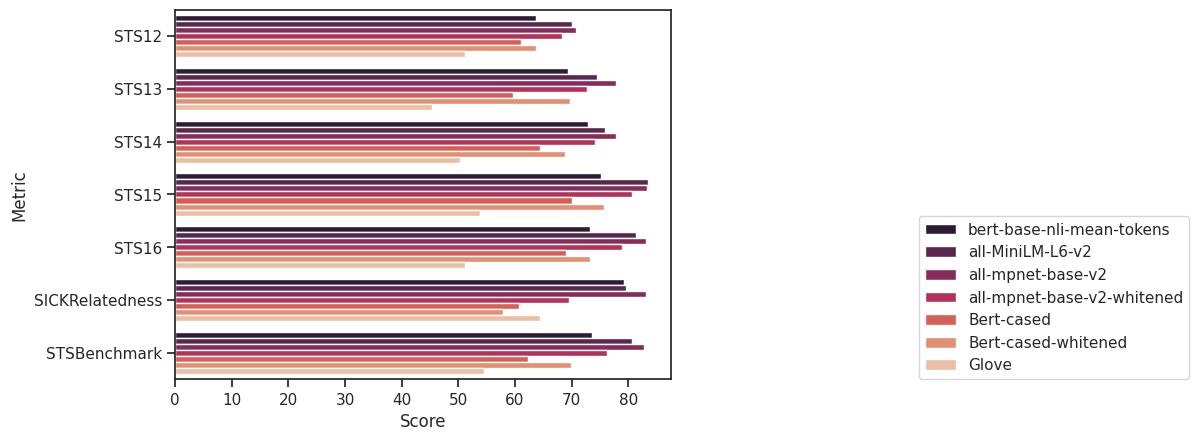

In [65]:
sns.barplot(data,
            y="Metric",
            x="Score",
            hue="Model",
            palette = 'rocket')
sns.set_theme(style="ticks")
plt.legend(loc=(1.5, 0))

## Classification Tasks

In [16]:
AccuracyDf['Accuracy'] = AccuracyDf['Accuracy'] *100

In [17]:
AccuracyDf

,Model,Accuracy
0,Word2Vec,93.033708
1,bert-base-nli-mean-tokens,95.955056
2,all-MiniLM-L6-v2,96.629213
3,all-mpnet-base-v2,97.303371
4,bert-base-uncased,96.629213
5,Angle_Llama,93.483146


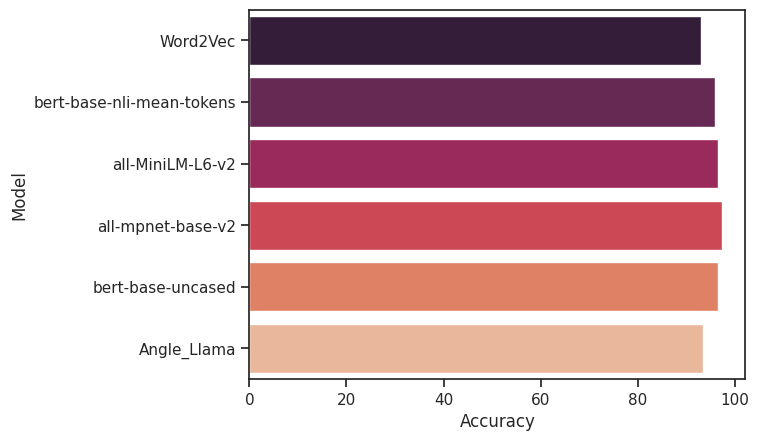

In [50]:
sns.barplot(y='Model',x= 'Accuracy', data = AccuracyDf, palette = "rocket")
# Show the plot
plt.show()